# Project 5: clustering models

You need **Yellowbrick** package for this notebook (https://www.scikit-yb.org/en/latest/index.html), check your install.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from fonctions_eda import *
from time import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer, intercluster_distance
import copy
%matplotlib inline

This project was made with Python 3.8.8, **Matplotlib 3.4.2**, Pandas 1.2.4, Numpy 1.20.1, Seaborn 0.11.1. Chek your version number:

In [2]:
print("Python", sys.version_info.major, ".", sys.version_info.minor)
print("Matplotlib", mpl.__version__)
print("Pandas", pd.__version__)
print("Nympy", np.__version__)
print("Seaborn", sns.__version__)

Python 3 . 8
Matplotlib 3.4.2
Pandas 1.2.4
Nympy 1.20.1
Seaborn 0.11.1


In [3]:
# For a better visualisation:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.rcParams.update({"figure.titlesize":16, "axes.titlesize":15, "axes.labelsize":14, "xtick.labelsize":14, "ytick.labelsize":14})

## Load data

Add the path to the file containing the .csv files of the project:

In [4]:
path = "E:/Mes Docs/Sciences/Cours/OpenclassroomsDS-ML/Projet5"

In [5]:
path_customers_unique = os.path.join(path, "customers_unique.csv")

Loading data with pandas.

In [6]:
customers_unique = pd.read_csv(path_customers_unique, encoding="utf-8")

In [7]:
customers_unique.drop('Unnamed: 0', axis=1, inplace=True)
customers_unique.head()

,customer_unique_id,order_id,n_orders,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delivery_time,delivery_time_days_mean,delivery_difference,delivery_difference_days_mean,delivered_proba,product_id,n_products_mean,n_products_total,product_category_name_english,seller_id,n_sellers_mean,n_sellers_total,seller_city,seller_state,n_payments_mean,payment_types,price_order_mean,price_order_total,review_id,review_score_mean,proba_review_title,proba_review_msg,timelapse_review_creation_answer_mean,n_payment_types,customer_city,customer_state,customer_city_population_2010,city_lat,city_lon,most_recent_order,recency,recency_float_days
0,0000366f3b9a7992bf8c76cfdf3221e2,['e22acc9c116caa3f2b7121bbb380d08e'],1,[Timestamp('2018-05-10 10:56:27')],[Timestamp('2018-05-16 20:48:37')],[Timestamp('2018-05-21 00:00:00')],[Timedelta('6 days 09:52:10')],6.41,[Timedelta('4 days 03:11:23')],4.13,1.00,['372645c7439f9661fbbacfd129aa92ec'],1.00,1.00,['bed_bath_table'],['da8622b14eb17ae2831f4ac5b9dab84a'],1.00,1.00,['piracicaba'],['SP'],1.00,['credit_card'],129.90,129.90,['13359f48c3c7e41a2b8afca340937eeb'],5.00,1.00,1.00,4.57,1,cajamar,SP,64114.00,-23.39,-46.85,2018-05-10 10:56:27,-161 days +17:26:09,-160.27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,['3594e05a005ac4d06a72673270ef9ec9'],1,[Timestamp('2018-05-07 11:11:27')],[Timestamp('2018-05-10 18:02:42')],[Timestamp('2018-05-15 00:00:00')],[Timedelta('3 days 06:51:15')],3.29,[Timedelta('4 days 05:57:18')],4.25,1.00,['5099f7000472b634fea8304448d20825'],1.00,1.00,['health_beauty'],['138dbe45fc62f1e244378131a6801526'],1.00,1.00,['sao paulo'],['SP'],1.00,['credit_card'],18.90,18.90,['e383e10e36a765f04f752a37c1674e43'],4.00,0.00,0.00,0.94,1,osasco,SP,666740.00,-23.54,-46.79,2018-05-07 11:11:27,-164 days +17:41:09,-163.26
2,0000f46a3911fa3c0805444483337064,['b33ec3b699337181488304f362a6b734'],1,[Timestamp('2017-03-10 21:05:03')],[Timestamp('2017-04-05 14:38:47')],[Timestamp('2017-04-07 00:00:00')],[Timedelta('25 days 17:33:44')],25.73,[Timedelta('1 days 09:21:13')],1.39,1.00,['64b488de448a5324c4134ea39c28a34b'],1.00,1.00,['stationery'],['3d871de0142ce09b7081e2b9d1733cb1'],1.00,1.00,['campo limpo paulista'],['SP'],1.00,['credit_card'],69.00,69.00,['d89cb4217c23008b141e66c3160de8a4'],3.00,0.00,0.00,1.06,1,sao jose,SC,209804.00,-27.59,-48.63,2017-03-10 21:05:03,-586 days +03:34:45,-585.85
3,0000f6ccb0745a6a4b88665a16c9f078,['41272756ecddd9a9ed0180413cc22fb6'],1,[Timestamp('2017-10-12 20:29:41')],[Timestamp('2017-11-01 21:23:05')],[Timestamp('2017-11-13 00:00:00')],[Timedelta('20 days 00:53:24')],20.04,[Timedelta('11 days 02:36:55')],11.11,1.00,['2345a354a6f2033609bbf62bf5be9ef6'],1.00,1.00,['telephony'],['ef506c96320abeedfb894c34db06f478'],1.00,1.00,['sao paulo'],['SP'],1.00,['credit_card'],25.99,25.99,['6f22e4ad2cd9e0d40c5842e4787b4321'],4.00,0.00,1.00,1.01,1,belem,PA,1393399.00,-1.49,-48.36,2017-10-12 20:29:41,-370 days +02:59:23,-369.88
4,0004aac84e0df4da2b147fca70cf8255,['d957021f1127559cd947b62533f484f7'],1,[Timestamp('2017-11-14 19:45:42')],[Timestamp('2017-11-27 23:08:56')],[Timestamp('2017-12-05 00:00:00')],[Timedelta('13 days 03:23:14')],13.14,[Timedelta('7 days 00:51:04')],7.04,1.00,['c72e18b3fe2739b8d24ebf3102450f37'],1.00,1.00,['telephony'],['70a12e78e608ac31179aea7f8422044b'],1.00,1.00,['jacarei'],['SP'],1.00,['credit_card'],180.00,180.00,['880a77e7dd4e496969f138f974cc44a1'],5.00,0.00,0.00,4.94,1,sorocaba,SP,586625.00,-23.49,-47.47,2017-11-14 19:45:42,-337 days +02:15:24,-336.91


## Transactions and satisfaction clustering

We select variables dealing with number of items, money spent,  client satisfaction (review score) and customer city population to characterize our customers transaction habits.

In [8]:
data_clustering = customers_unique[
    ['n_products_total', 'price_order_total', 'review_score_mean', 'customer_city_population_2010']
    ].copy()

We need to delete a few outliers on the total money spent to ease the clustering:

In [9]:
# Define and drop outliers:
outliers = data_clustering[data_clustering['price_order_total']>5000].index
print(f'We will drop {len(outliers)} outliers.')
data_clustering.drop(index=outliers, inplace=True)

# make a clean index for clustering:
data_clustering.reset_index(inplace=True)
data_clustering.drop('index', axis=1, inplace=True)

We will drop 7 outliers.


We will scale the data using different scalers: a basic StandardScaler, and scalers more robust to outliers such as MinMaxScaler and Robust scaler.

We will test K-means for 2 to 9 clusters and evaluate it with different scores (inertia, silhouette score, Davies-Bouldin score).

In [10]:
preprocessors = [StandardScaler(), MinMaxScaler(), RobustScaler()]
preprocessors_names = ['StandardScaler'] * 8 + ['MinMaxScaler'] * 8 + ['RobustScaler'] * 8
n_clusters = [i for i in range(2, 10)] * 3
fit_times = []
inertia = []
silhouettes = []
davies_bouldin = []

for preprocessor in preprocessors:
    for n in range(2, 10):
        model = make_pipeline(preprocessor, KMeans(n_clusters=n, random_state=0))
        t0 = time()
        model.fit(data_clustering)
        ft = time() - t0
        iner = model[-1].inertia_
        sil = silhouette_score(data_clustering, model[-1].labels_)
        db = davies_bouldin_score(data_clustering, model[-1].labels_)
        fit_times.append(ft)
        inertia.append(iner)
        silhouettes.append(sil)
        davies_bouldin.append(db)
results = pd.DataFrame({'preprocessor':preprocessors_names, 'n_clusters':n_clusters, 'fit_time':fit_times, 'inertia':inertia,
    'silhouette_score':silhouettes, 'davies_bouldin_score':davies_bouldin})
results

KeyboardInterrupt: 

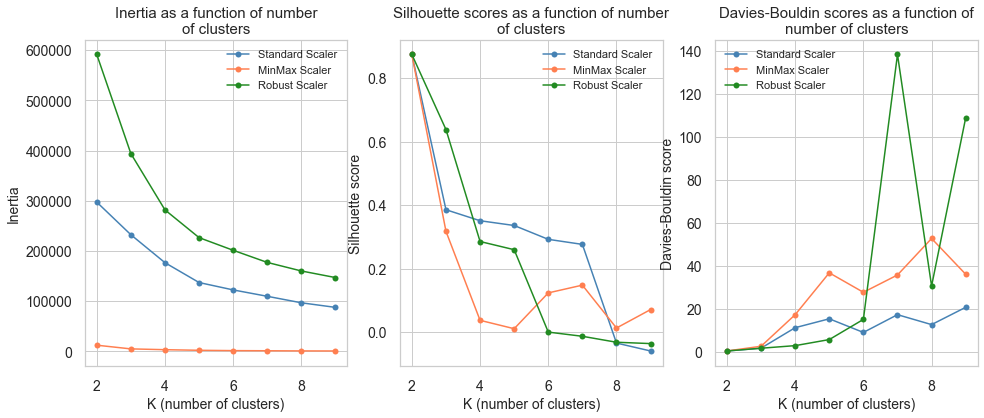

In [ ]:
# Plotting results of the score metrics as a function of number of clusters and scalers:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

scores = ['inertia', 'silhouette_score', 'davies_bouldin_score']
titles = ['Inertia as a function of number\nof clusters',
    'Silhouette scores as a function of number\nof clusters', 
    'Davies-Bouldin scores as a function of\nnumber of clusters']
y_labels = ['Inertia', 'Silhouette score', 'Davies-Bouldin score']

for axe, score, title, ylab in zip([0, 1, 2], scores, titles, y_labels):
    ax[axe].plot(range(2, 10), results[score][:8], marker='o', color='steelblue', label='Standard Scaler')
    ax[axe].plot(range(2, 10), results[score][8:16], marker='o', color='coral', label='MinMax Scaler')
    ax[axe].plot(range(2, 10), results[score][16:], marker='o', color='forestgreen', label='Robust Scaler')
    ax[axe].set_title(title)
    ax[axe].set_xlabel('K (number of clusters)')
    ax[axe].set_ylabel(ylab)
    ax[axe].legend()

#fig.savefig("transactional_scores.png", bbox_inches="tight", dpi=150);

The robust scaler gives good silhouette (highest) and Davies-Bouldin (minimum) scores for 3 clusters with the highest inertia explained. The standard scaler is second best for inertia explained but have lower results for the silhouette score between 2 and 5 clusters. The min-max scaler yield results that do not explain a lot of inertia compared to the two other scalers but with overall good silhouette and Davies-Bouldin scores.

We will use the k-elbow method on the distorsion score to determine the best number of clusters.

In [11]:
# Transform data with the various scalers:
X_scaled_robust = RobustScaler().fit_transform(data_clustering)
X_scaled_standard = StandardScaler().fit_transform(data_clustering)
X_scaled_minmax = MinMaxScaler().fit_transform(data_clustering)

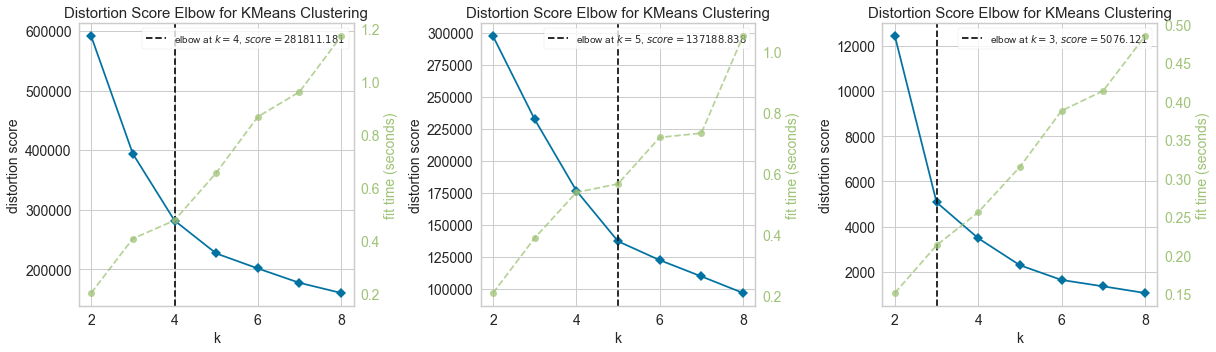

In [12]:
fig, (ax1, ax2, ax3)  = plt.subplots(1, 3, figsize=(17, 5), tight_layout=True)

visualizer = KElbowVisualizer(KMeans(random_state=0), ax=ax1, k=(2,9) )
visualizer.fit(X_scaled_robust)
visualizer.finalize()

visualizer = KElbowVisualizer(KMeans(random_state=0), ax=ax2, k=(2,9) )
visualizer.fit(X_scaled_standard)
visualizer.finalize()

visualizer = KElbowVisualizer(KMeans(random_state=0), ax=ax3, k=(2,9) )
visualizer.fit(X_scaled_minmax)
visualizer.finalize()

#fig.savefig("transactional_elbow.png", bbox_inches="tight", dpi=150);

The elbow method suggest 4 clusters as the best number for with Robust Scaler, 6 for the Standard Scaler, and 3 clusters for the Min-Max scaler. This is consistant with the other metrics we used that give best results around 3-5 clusters.

We will use the silhouette score visualizer on the best number of cluster for each scaler.

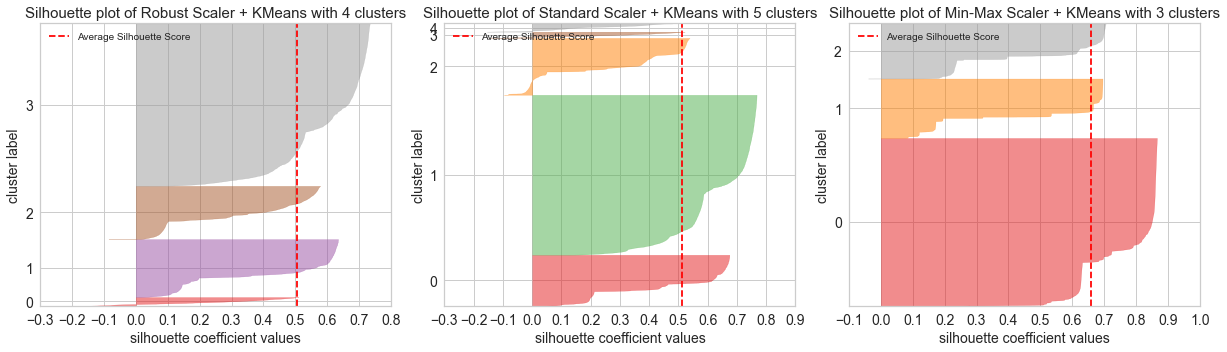

In [13]:
fig, (ax1, ax2, ax3)  = plt.subplots(1, 3, figsize=(17, 5), tight_layout=True)

visualizer = SilhouetteVisualizer(KMeans(4, random_state=0), ax=ax1,
    title='Silhouette plot of Robust Scaler + KMeans with 4 clusters')
visualizer.fit(X_scaled_robust)
visualizer.finalize()

visualizer = SilhouetteVisualizer(KMeans(5, random_state=0), ax=ax2,
    title='Silhouette plot of Standard Scaler + KMeans with 5 clusters')
visualizer.fit(X_scaled_standard)
visualizer.finalize()

visualizer = SilhouetteVisualizer(KMeans(3, random_state=0), ax=ax3, 
    title='Silhouette plot of Min-Max Scaler + KMeans with 3 clusters')
visualizer.fit(X_scaled_minmax)
visualizer.finalize()

#fig.savefig("transactional_silplots.png", bbox_inches="tight", dpi=150);

The average silhouette score and shape of clusters is better/clearer with the min-max scaler, second best being the robust scaler. The standard scaler gives a lower score.

Since the robust scaler explains more inertia and also have a good Davies-Bouldin score, we will prefer this scaler to the min-max one, and use it in the rest of our analysis. We will plot the clusters according to the first 2 main axis of the CPA.

In [22]:
# Use the scaled data for CPA:
pca = PCA(n_components=2)
pca.fit(X_scaled_robust)
X_trans = pca.transform(X_scaled_robust)

In [23]:
# Get data for 3 clusters:
cls_robust_3 = make_pipeline(RobustScaler(), KMeans(n_clusters=3, random_state=0))
cls_robust_3.fit(data_clustering)

# Get data for 4 clusters:
cls_robust_4 = make_pipeline(RobustScaler(), KMeans(n_clusters=4, random_state=0))
cls_robust_4.fit(data_clustering)

# Get data for 5 clusters:
cls_robust_5 = make_pipeline(RobustScaler(), KMeans(n_clusters=5, random_state=0))
cls_robust_5.fit(data_clustering)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('kmeans', KMeans(n_clusters=5, random_state=0))])

ValueError: 'c' argument has 96022 elements, which is inconsistent with 'x' and 'y' with size 96029.

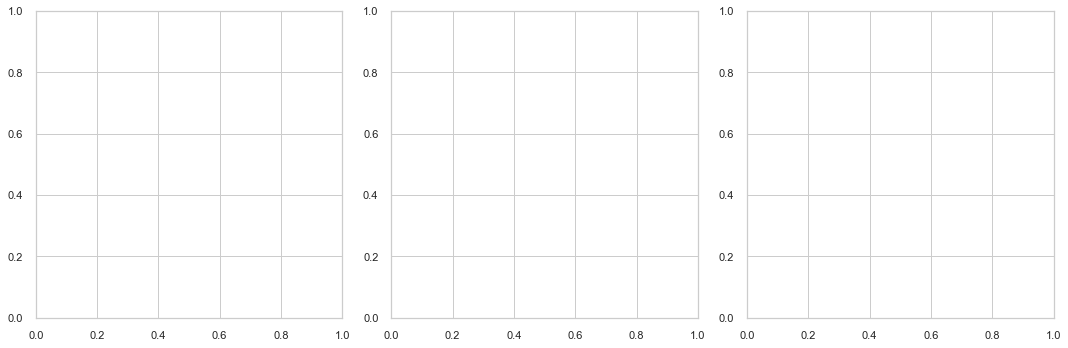

In [57]:
# Compare clustering at 3, 4, 5 clusters with projection on the first 2 main CPA axis:
labels = [
    cls_robust_3[-1].labels_, cls_robust_4[-1].labels_, cls_robust_5[-1].labels_
    ]
titles = [
    'KMeans with robust scaler - 3 clusters', 'KMeans with robust scaler - 4 clusters', 'KMeans with robust scaler - 5 clusters'
    ]

fig, ax = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

for axe, label, title in zip([0, 1, 2], labels, titles):
    ax[axe].scatter(X_trans[:, 1], X_trans[:, 0], c=label)
    ax[axe].set_title(title)
    ax[axe].set_xlabel('PCA main axis 2')
    ax[axe].set_ylabel('PCA main axis 1')

#fig.savefig("transactional_clusters.png", bbox_inches="tight", dpi=150);

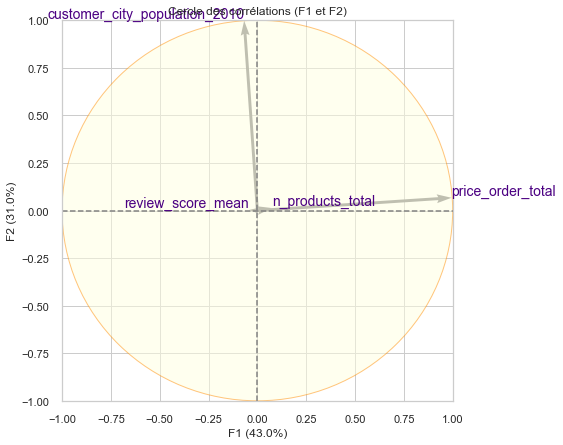

In [25]:
pcs = pca.components_
features = ['n_products_total', 'price_order_total', 'review_score_mean', 'customer_city_population_2010']
display_circles(pcs, 2, pca, [(0,1)], labels = np.array(features))

The first CPA axis is correlated with the customer city population, the second axis with both the total money spent (`price_order_total`) and the number of products bought. The review score is not well projected on theses axis.

The clusters are well separated on the first CPA axis but show a rather continuous trend on the second with a rather arbitrary separation. The best number of clusters being 4, We can have a look at the mean for each variable for 4 clusters.

In [26]:
# Compare mean of each variables for 4 clusters:
data_clustering['cluster'] = cls_robust_4[-1].labels_
mean_robust_4 = data_clustering.groupby('cluster').mean()

# Add percentage of customer per cluster:
perc_cust = data_clustering.groupby('cluster').count() / data_clustering.shape[0] * 100
perc_cust.drop(columns=['price_order_total', 'review_score_mean', 'customer_city_population_2010'], inplace=True)
perc_cust.rename(columns={'n_products_total':'percentage of customers'}, inplace=True)
mean_robust_4 = pd.concat([mean_robust_4, perc_cust], axis=1)

# Rename index
mean_robust_4.reset_index(inplace=True)
mean_robust_4

,cluster,n_products_total,price_order_total,review_score_mean,customer_city_population_2010,percentage of customers
0,0,1.16,109.18,4.26,9988603.77,20.54
1,1,1.13,112.16,4.74,536329.47,57.53
2,2,1.59,1018.54,4.00,2089681.93,3.08
3,3,1.20,119.65,1.83,1003052.10,18.85


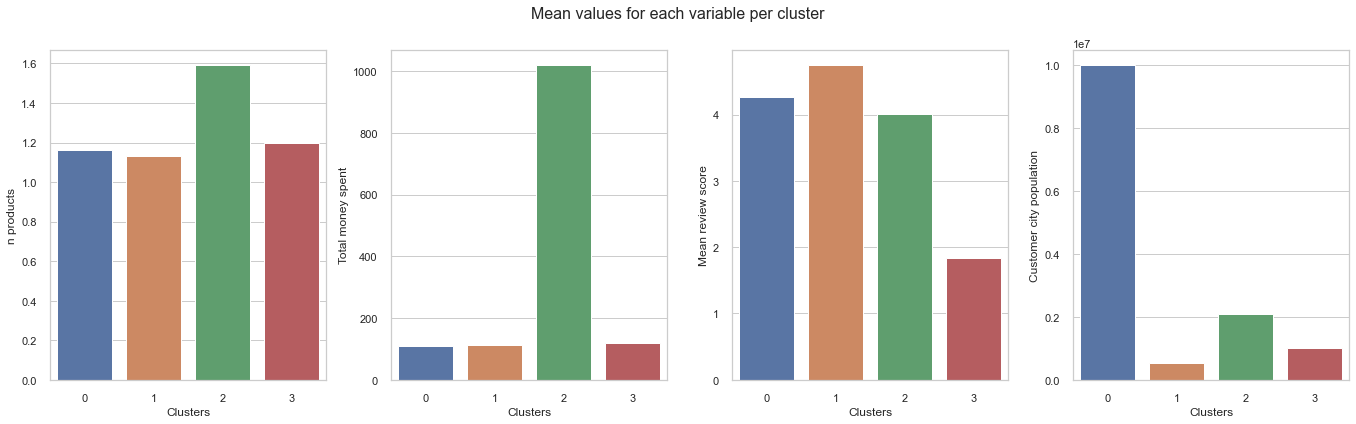

In [27]:
y_label =[
    'n products', 'Total money spent', 'Mean review score', 'Customer city population'
    ]
data_mean = [
    'n_products_total', 'price_order_total', 'review_score_mean', 'customer_city_population_2010'
    ]

fig, ax = plt.subplots(1, 4, figsize=(19, 6), tight_layout=True)
fig.suptitle('Mean values for each variable per cluster')

for axe, data,  ylab in zip([0, 1, 2, 3], data_mean, y_label):
    sns.barplot(ax=ax[axe], data=mean_robust_4, y=data, x='cluster', hue='cluster', ci=95, dodge=False)
    ax[axe].set_xticks(mean_robust_4.index)
    ax[axe].set_xticklabels(mean_robust_4.cluster)
    ax[axe].set_xlabel('Clusters')
    ax[axe].set_ylabel(ylab)
    ax[axe].legend([], [], frameon=False)

#fig.savefig("transactional_means.png", bbox_inches="tight", dpi=150);

* Megalopole customers (20% of clients): corresponds to satisfied clients spending low amount of money, they tend to live in very large cities and megalopoles (about 10 million inhabitants).
* Disatisfied customers (19% of clients): correspond to disatisfied clients (very low review score), who spend a much lower amount of money, and live in large cities (about 1 million inhabitants).
* Small cities customers (58% of clients):  correspond to satisfied clients spending low amount of money, but living in smaller cities (about 500 000 inhabitants).
* High value clients (3% of clients): corresponds to customers who spent a lot of money and bought more products than other customers. They are quite satisfied (high review score) and live in large cities of about 2 million inhabitants.


The 'small cities customers' cluster contains more than 60% of the customers, 'megalopole customers' cluster  about 20%, 'disatisfied customers' cluster about 13% and 'high value clients' cluster less than 3%. This last cluster contains only a small proportion ofcustomers, but includes the highest value clients (who spend the most money), hence is important in our analysis.

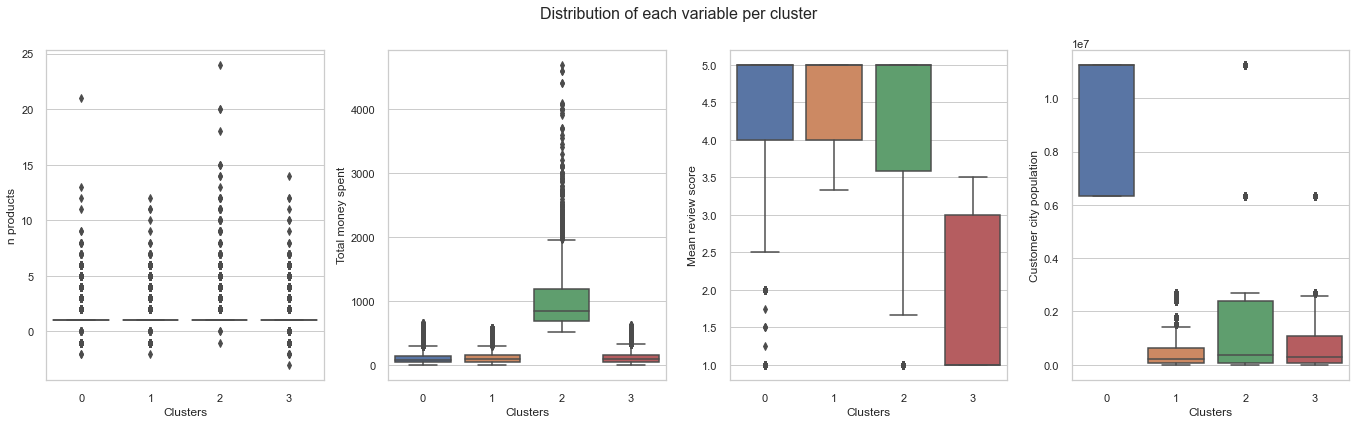

In [33]:
y_label =[
    'n products', 'Total money spent', 'Mean review score', 'Customer city population'
    ]
datas = [
    'n_products_total', 'price_order_total', 'review_score_mean', 'customer_city_population_2010'
    ]

fig, ax = plt.subplots(1, 4, figsize=(19, 6), tight_layout=True)
fig.suptitle('Distribution of each variable per cluster')

for axe, data,  ylab in zip([0, 1, 2, 3], datas, y_label):
    sns.boxplot(ax=ax[axe], data=data_clustering, x=data_clustering["cluster"], y=data_clustering[data])
    #barplot(ax=ax[axe], data=mean_robust_4, y=data, x='cluster', hue='cluster', ci=95, dodge=False)
    ax[axe].set_xticks(mean_robust_4.index)
    ax[axe].set_xticklabels(mean_robust_4.cluster)
    ax[axe].set_xlabel('Clusters')
    ax[axe].set_ylabel(ylab)
    ax[axe].legend([], [], frameon=False)

Since the total amount of money spent and the number of products bought is correlated, we will make a 3D view of the cluster using the true values of the variables without plotting the number of orders.

Text(0.5, 0, 'Total money spent (B$)')

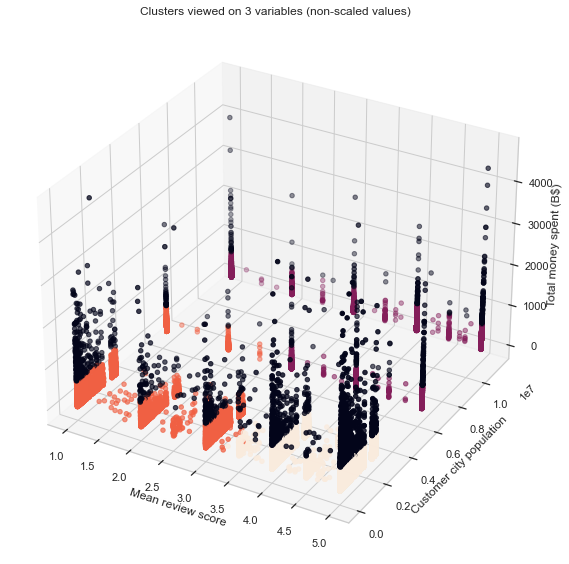

In [20]:
fig = plt.figure(figsize=(8, 8), tight_layout=True)
ax = fig.add_subplot(projection='3d')

ax.scatter(data_clustering['review_score_mean'], data_clustering['customer_city_population_2010'], 
    data_clustering['price_order_total'], c=cls_robust_4[-1].labels_)
ax.set_title('Clusters viewed on 3 variables (non-scaled values)')
ax.set_xlabel('Mean review score')
ax.set_ylabel('Customer city population')
ax.set_zlabel('Total money spent (B$)')

#fig.savefig("transactional_3d.png", bbox_inches="tight", dpi=150);

## RFM clustering (Recency, Frequency, Monetary)

Now we will concentrate on a classical RFm clustering taking into account the number of days from the last order (recency), the number of orders (frequency) and the total money spent (monetary).

In [34]:
data_rfm = customers_unique[[
    'recency_float_days', 'n_orders', 'price_order_mean'
    ]].copy()

We drop a few outliers of the monetary variable for a bette clustering.

In [35]:
# Define and drop outliers:
outliers_price_order = data_rfm[data_rfm['price_order_mean']>10_000].index
outliers_n_orders = data_rfm[data_rfm['n_orders']>10].index

print(f'We will drop {len(outliers_price_order)} outliers related to monetary.')
print(f'We will drop {len(outliers_n_orders)} outliers related to frequency.')

data_rfm.drop(index=outliers_price_order, inplace=True)
data_rfm.drop(index=outliers_n_orders, inplace=True)

# make a clean index for clustering:
data_rfm.reset_index(inplace=True)
data_rfm.drop('index', axis=1, inplace=True)

We will drop 1 outliers related to monetary.
We will drop 1 outliers related to frequency.


In [36]:
data_rfm.head()

,recency_float_days,n_orders,price_order_mean
0,-160.27,1,129.90
1,-163.26,1,18.90
2,-585.85,1,69.00
3,-369.88,1,25.99
4,-336.91,1,180.00


We still test 3 scalers and calculate inertia, silhouette and Davies-Bouldin scores for 2 to 9 clusters.

In [47]:
preprocessors = [StandardScaler(), MinMaxScaler(), RobustScaler()]
preprocessors_names = ['StandardScaler'] * 8 + ['MinMaxScaler'] * 8 + ['RobustScaler'] * 8
n_clusters = [i for i in range(2, 10)] * 3
fit_times = []
inertia = []
silhouettes = []
davies_bouldin = []

for preprocessor in preprocessors:
    for n in range(2, 10):
        model = make_pipeline(preprocessor, KMeans(n_clusters=n, random_state=0))
        t0 = time()
        model.fit(data_rfm)
        ft = time() - t0
        iner = model[-1].inertia_
        sil = silhouette_score(data_rfm, model[-1].labels_)
        db = davies_bouldin_score(data_rfm, model[-1].labels_)
        fit_times.append(ft)
        inertia.append(iner)
        silhouettes.append(sil)
        davies_bouldin.append(db)
results_rfm = pd.DataFrame({'preprocessor':preprocessors_names, 'n_clusters':n_clusters, 'fit_time':fit_times, 'inertia':inertia,
    'silhouette_score':silhouettes, 'davies_bouldin_score':davies_bouldin})
results_rfm

,preprocessor,n_clusters,fit_time,inertia,silhouette_score,davies_bouldin_score
0,StandardScaler,2,0.23,205328.30,-0.08,13.77
1,StandardScaler,3,0.37,139756.22,0.18,2.71
2,StandardScaler,4,0.54,88375.46,0.28,1.98
3,StandardScaler,5,0.57,72797.73,0.32,1.66
4,StandardScaler,6,0.67,58094.14,0.35,2.57
5,StandardScaler,7,0.99,48823.73,0.35,5.01
6,StandardScaler,8,1.11,42797.62,0.37,4.36
7,StandardScaler,9,1.28,38248.99,0.31,4.14
8,MinMaxScaler,2,0.25,1269.11,0.40,1.08
9,MinMaxScaler,3,0.40,643.95,0.31,1.35


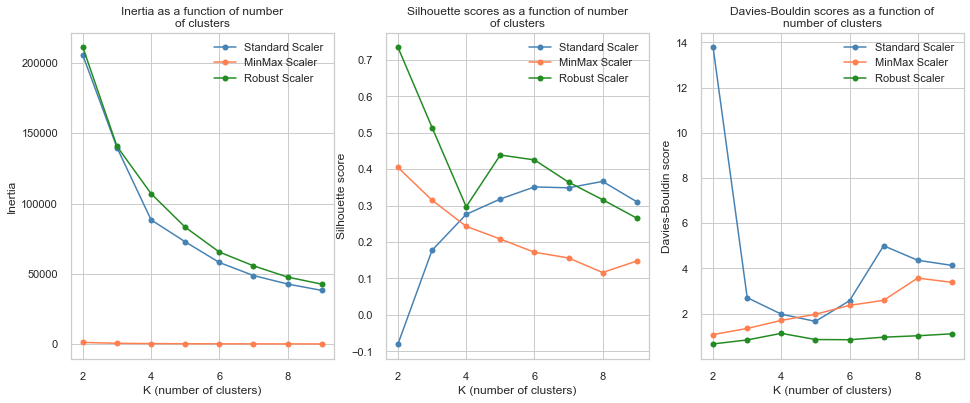

In [48]:
# Plotting results of the score metrics as a function of number of clusters and scalers:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

scores = ['inertia', 'silhouette_score', 'davies_bouldin_score']
titles = ['Inertia as a function of number\nof clusters',
    'Silhouette scores as a function of number\nof clusters', 
    'Davies-Bouldin scores as a function of\nnumber of clusters']
y_labels = ['Inertia', 'Silhouette score', 'Davies-Bouldin score']

for axe, score, title, ylab in zip([0, 1, 2], scores, titles, y_labels):
    ax[axe].plot(range(2, 10), results_rfm[score][:8], marker='o', color='steelblue', label='Standard Scaler')
    ax[axe].plot(range(2, 10), results_rfm[score][8:16], marker='o', color='coral', label='MinMax Scaler')
    ax[axe].plot(range(2, 10), results_rfm[score][16:], marker='o', color='forestgreen', label='Robust Scaler')
    ax[axe].set_title(title)
    ax[axe].set_xlabel('K (number of clusters)')
    ax[axe].set_ylabel(ylab)
    ax[axe].legend()

#fig.savefig("rfm_score.png", bbox_inches="tight", dpi=150);

Robust and Standard scalers give best overall results: the Standard scaler explains a little more inertia, the Robust scaler gives better silhouette and Davies-Bouldin scores. The Min-Max scaler is not very good for the 3 criterias.

We will find the best number of cluster with the elbow method.

In [37]:
X_scaled_robust_rfm = RobustScaler().fit_transform(data_rfm)
X_scaled_standard_rfm = StandardScaler().fit_transform(data_rfm)
X_scaled_minmax_rfm = MinMaxScaler().fit_transform(data_rfm)

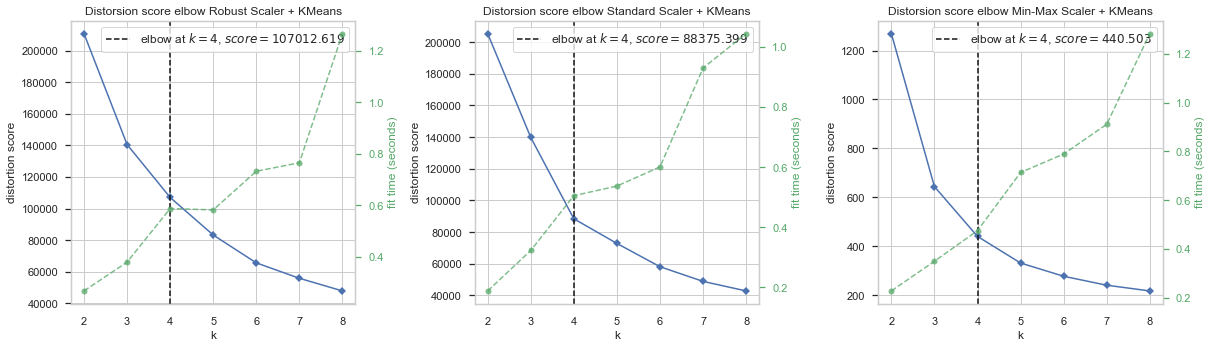

In [38]:
fig, (ax1, ax2, ax3)  = plt.subplots(1, 3, figsize=(17, 5), tight_layout=True)

visualizer = KElbowVisualizer(KMeans(random_state=0), ax=ax1, k=(2,9), 
    title='Distorsion score elbow Robust Scaler + KMeans')
visualizer.fit(X_scaled_robust_rfm)
visualizer.finalize()

visualizer = KElbowVisualizer(KMeans(random_state=0), ax=ax2, k=(2,9),
    title='Distorsion score elbow Standard Scaler + KMeans')
visualizer.fit(X_scaled_standard_rfm)
visualizer.finalize()

visualizer = KElbowVisualizer(KMeans(random_state=0), ax=ax3, k=(2,9),
    title='Distorsion score elbow Min-Max Scaler + KMeans')
visualizer.fit(X_scaled_minmax_rfm)
visualizer.finalize()

#fig.savefig("rfm_elbow.png", bbox_inches="tight", dpi=150);

The elbow method suggest a best number of clusters at 5 for the Robust and Standard scaler, and 4 with the Min-Max scaler.

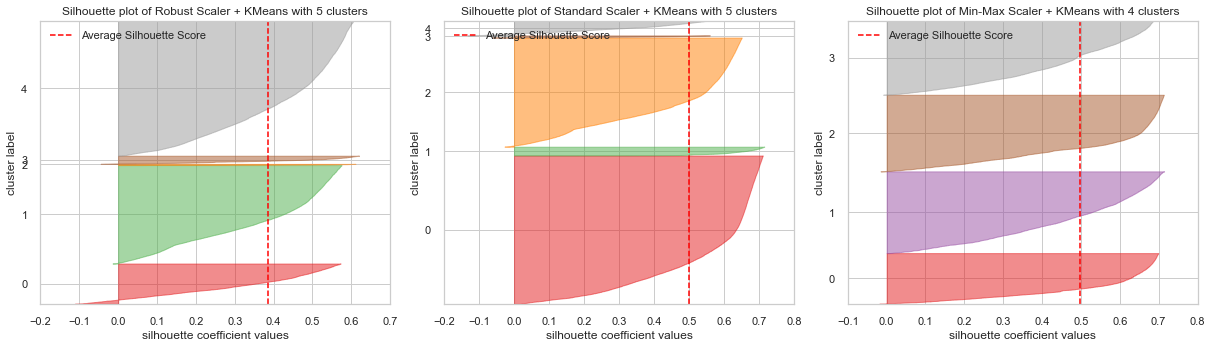

In [39]:
fig, (ax1, ax2, ax3)  = plt.subplots(1, 3, figsize=(17, 5), tight_layout=True)

visualizer = SilhouetteVisualizer(KMeans(5, random_state=0), ax=ax1,
    title='Silhouette plot of Robust Scaler + KMeans with 5 clusters')
visualizer.fit(X_scaled_robust_rfm)
visualizer.finalize()

visualizer = SilhouetteVisualizer(KMeans(5, random_state=0), ax=ax2,
    title='Silhouette plot of Standard Scaler + KMeans with 5 clusters')
visualizer.fit(X_scaled_standard_rfm)
visualizer.finalize()

visualizer = SilhouetteVisualizer(KMeans(4, random_state=0), ax=ax3,
    title='Silhouette plot of Min-Max Scaler + KMeans with 4 clusters')
visualizer.fit(X_scaled_minmax_rfm)
visualizer.finalize()

#fig.savefig("rfm_silplot.png", bbox_inches="tight", dpi=150);

The silhouette plot indicates disproportionned sizes of clusters for Robust scaler and Standard scaler (3 rather big clusters, 2 very small). The plot for the Min-Max scaler shows 3 large clusters and one very small. The average silhouette scores are quite similar, with slightly bette score for the Min-Max scaler.

In [40]:
# Use the scaled data for CPA:
pca = PCA(n_components=2)
pca.fit(X_scaled_standard_rfm)
X_trans_rfm = pca.transform(X_scaled_standard_rfm)

In [41]:
# Get data for 3 clusters:
cls4_standard_rfm = make_pipeline(StandardScaler(), KMeans(n_clusters=4, random_state=0))
cls4_standard_rfm.fit(data_rfm)

# Get data for 4 clusters:
cls5_standard_rfm = make_pipeline(StandardScaler(), KMeans(n_clusters=5, random_state=0))
cls5_standard_rfm.fit(data_rfm)

# Get data for 5 clusters:
cls6_standard_rfm = make_pipeline(StandardScaler(), KMeans(n_clusters=6, random_state=0))
cls6_standard_rfm.fit(data_rfm)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=6, random_state=0))])

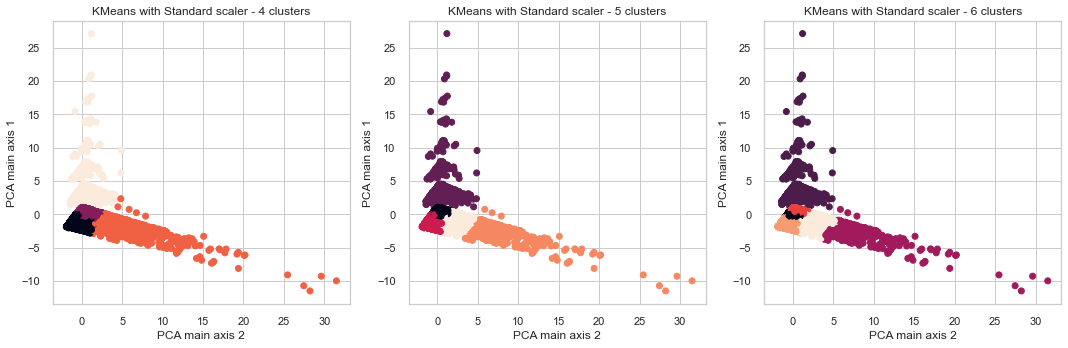

In [56]:
# Compare clustering at 4, 5, 6 clusters with projection on the first 2 main CPA axis:
labels = [
    cls4_standard_rfm[-1].labels_, cls5_standard_rfm[-1].labels_, cls6_standard_rfm[-1].labels_
    ]
titles = [
    'KMeans with Standard scaler - 4 clusters', 'KMeans with Standard scaler - 5 clusters', 
    'KMeans with Standard scaler - 6 clusters'
    ]

fig, ax = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

for axe, label, title in zip([0, 1, 2], labels, titles):
    ax[axe].scatter(X_trans_rfm[:, 1], X_trans_rfm[:, 0], c=label)
    ax[axe].set_title(title)
    ax[axe].set_xlabel('PCA main axis 2')
    ax[axe].set_ylabel('PCA main axis 1')

#fig.savefig("rfm_clusters.png", bbox_inches="tight", dpi=150);

The clusters spread moderately well along the main CPA axis, with a better separation along the second axis. Clustering along the first axis is rather arbitrary.

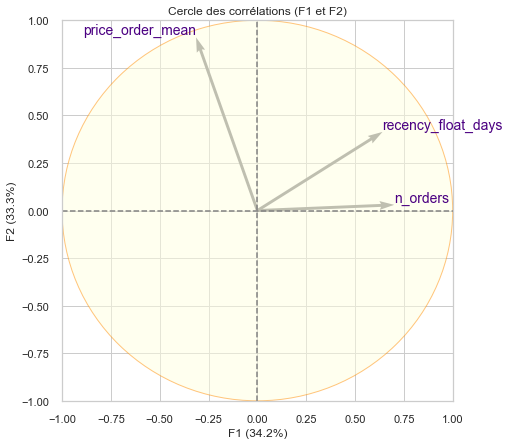

In [43]:
pcs = pca.components_

features = ['recency_float_days', 'n_orders', 'price_order_mean']

display_circles(pcs, 2, pca, [(0,1)], labels = np.array(features))

The first main CPA axis is anti-correlated with recency: recent clients will be represented at the bottom of the correlation circle, old clients in the top part. The second main CPA axis is correlated with the monetary and frequency values (`price_order_total` and `n_orders`): clients spending a lot will be on the right part, low value clients on the left part.

Considering inertia, scores and explicability, we will focus on the approach using the Standard scaler with 5 clusters.

In [44]:
# Compare mean of each variables for 4 clusters:
data_rfm['cluster'] = cls5_standard_rfm[-1].labels_
rfm_mean_standard_5 = data_rfm.groupby('cluster').mean()

# Add percentage of customer per cluster:
rfm_perc_cust = data_rfm.groupby('cluster').count() / data_rfm.shape[0] * 100
rfm_perc_cust.drop(columns=['recency_float_days', 'n_orders'], inplace=True)
rfm_perc_cust.rename(columns={'price_order_mean':'percentage of customers'}, inplace=True)
rfm_mean_standard_5 = pd.concat([rfm_mean_standard_5, rfm_perc_cust], axis=1)

# Reset index
rfm_mean_standard_5.reset_index(inplace=True)
rfm_mean_standard_5

,cluster,recency_float_days,n_orders,price_order_mean,percentage of customers
0,0,-178.01,1.00,98.76,52.41
1,1,-268.38,2.11,119.98,3.11
2,2,-440.38,1.00,99.70,38.58
3,3,-297.40,1.01,1761.75,0.74
4,4,-279.82,1.00,581.38,5.16


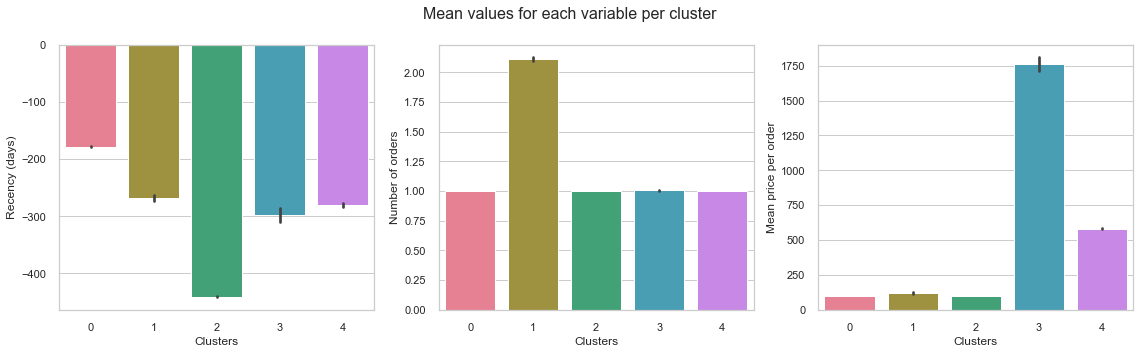

In [45]:
y_label =[
    'Recency (days)', 'Number of orders', 'Mean price per order'
    ]
data_mean = [
    'recency_float_days', 'n_orders', 'price_order_mean'
    ]

fig, ax = plt.subplots(1, 3, figsize=(16, 5), tight_layout=True)
fig.suptitle('Mean values for each variable per cluster')
rfm_colors=sns.color_palette("husl", 5)

for axe, data,  ylab in zip([0, 1, 2], data_mean, y_label):
    sns.barplot(ax=ax[axe], data=data_rfm, y=data, x='cluster', hue='cluster', estimator=np.mean, ci=95, 
        palette=rfm_colors, dodge=False)
    ax[axe].set_xticks(rfm_mean_standard_5.index)
    ax[axe].set_xticklabels(rfm_mean_standard_5.cluster)
    ax[axe].set_xlabel('Clusters')
    ax[axe].set_ylabel(ylab)
    ax[axe].legend([], [], frameon=False)

#fig.savefig("rfm_means.png", bbox_inches="tight", dpi=150);

We can analyse our clusters as follow:
* High value clients: 2 clusters representing 6% of clients
    - High Monetary (low frequencey, medium recency): 3% of customers spending a lot (mean = 1045 B$) on an average of 1 order, last order was about 10 mounth ago
    - High Frequency (medium monetary, medium recency): 3% of customers ordering more than average, of medium recency (mean last order 10 mounth ago), intermediate monetary (mean = 239 B$)
* High recency clients: about 36% of customers, spending rather low amount of money (mean = 114 B$) but with recent orders.
* Medium value client: about 36% of customers, also spending rather low amount of money (mean = 108 B$) and moderately recent (mean last order 10 mounth ago)
* Low value clients: about 22% of customers spent a low amount of money and ordered last time more than 1 year ago.

Recommendations of actions:
* High value clients: increase loyalty to make sure to keep theses clients active. Send custom commercials with discount offers.
* High recency client: convince them to buy more, create loyalty. Same as high value clients, they are important and you can target them with appropriate commercials and discount offers.
* Medium value clients: although they are not spending a lot, it may be good to reminde them of their previous orders on Olist to re-activate them.
* Low value clients: no action to take, they are too old to be worth activating and are lost clients.

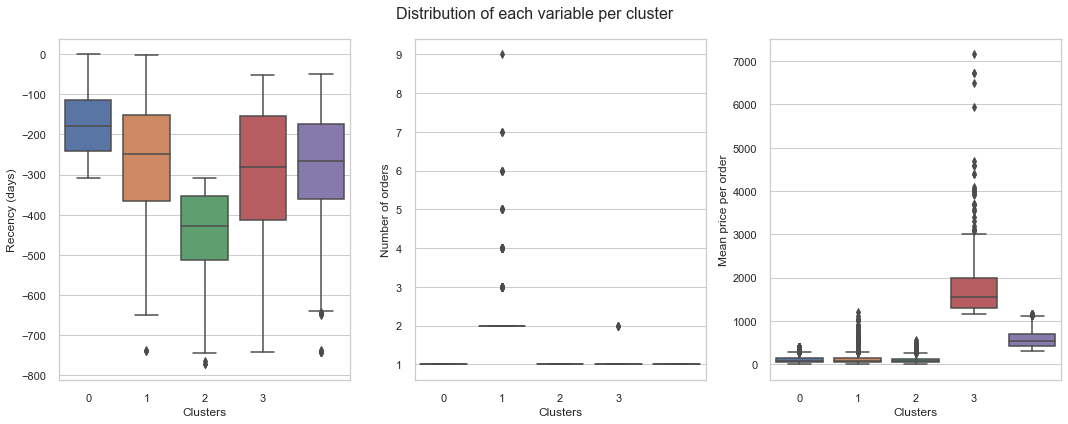

In [47]:
y_label =[
    'Recency (days)', 'Number of orders', 'Mean price per order'
    ]
datas = [
    'recency_float_days', 'n_orders', 'price_order_mean'
    ]

fig, ax = plt.subplots(1, 3, figsize=(15, 6), tight_layout=True)
fig.suptitle('Distribution of each variable per cluster')

for axe, data,  ylab in zip([0, 1, 2], datas, y_label):
    sns.boxplot(ax=ax[axe], data=data_rfm, x=data_rfm["cluster"], y=data_rfm[data])
    #barplot(ax=ax[axe], data=mean_robust_4, y=data, x='cluster', hue='cluster', ci=95, dodge=False)
    ax[axe].set_xticks(mean_robust_4.index)
    ax[axe].set_xticklabels(mean_robust_4.cluster)
    ax[axe].set_xlabel('Clusters')
    ax[axe].set_ylabel(ylab)
    ax[axe].legend([], [], frameon=False)

## Relational clustering: satisfaction, reviews and delivery dates profiling

We select variables related to customer activity (proportion of orders that lead to a review message or title), satisfaction (review score), difference between expected and true delivery date, and recency.

In [48]:
data_clustering_relational = customers_unique[
    ['delivery_difference_days_mean', 'review_score_mean', 'proba_review_title', 'recency_float_days', 'proba_review_msg']
    ].copy()

We can check the scores and inertia for 2 to 9 clusters for 3 scalers.

In [60]:
preprocessors = [StandardScaler(), MinMaxScaler(), RobustScaler()]
preprocessors_names = ['StandardScaler'] * 8 + ['MinMaxScaler'] * 8 + ['RobustScaler'] * 8
n_clusters = [i for i in range(2, 10)] * 3
fit_times = []
inertia = []
silhouettes = []
davies_bouldin = []

for preprocessor in preprocessors:
    for n in range(2, 10):
        model = make_pipeline(preprocessor, KMeans(n_clusters=n, random_state=0))
        t0 = time()
        model.fit(data_clustering_relational)
        ft = time() - t0
        iner = model[-1].inertia_
        sil = silhouette_score(data_clustering_relational, model[-1].labels_)
        db = davies_bouldin_score(data_clustering_relational, model[-1].labels_)
        fit_times.append(ft)
        inertia.append(iner)
        silhouettes.append(sil)
        davies_bouldin.append(db)
results_relational = pd.DataFrame({'preprocessor':preprocessors_names, 'n_clusters':n_clusters, 
    'fit_time':fit_times, 'inertia':inertia, 'silhouette_score':silhouettes, 
    'davies_bouldin_score':davies_bouldin})
results_relational

,preprocessor,n_clusters,fit_time,inertia,silhouette_score,davies_bouldin_score
0,StandardScaler,2,0.19,359382.34,0.08,1.27
1,StandardScaler,3,0.37,267340.72,-0.06,2.56
2,StandardScaler,4,0.37,176351.21,-0.09,2.35
3,StandardScaler,5,0.51,136377.53,-0.13,5.08
4,StandardScaler,6,0.65,101252.85,-0.03,2.44
5,StandardScaler,7,0.70,89460.50,-0.08,2.13
6,StandardScaler,8,0.84,78386.98,-0.12,3.64
7,StandardScaler,9,1.05,68205.48,-0.13,6.22
8,MinMaxScaler,2,0.17,24203.96,0.03,8.98
9,MinMaxScaler,3,0.23,16097.02,-0.08,3.44


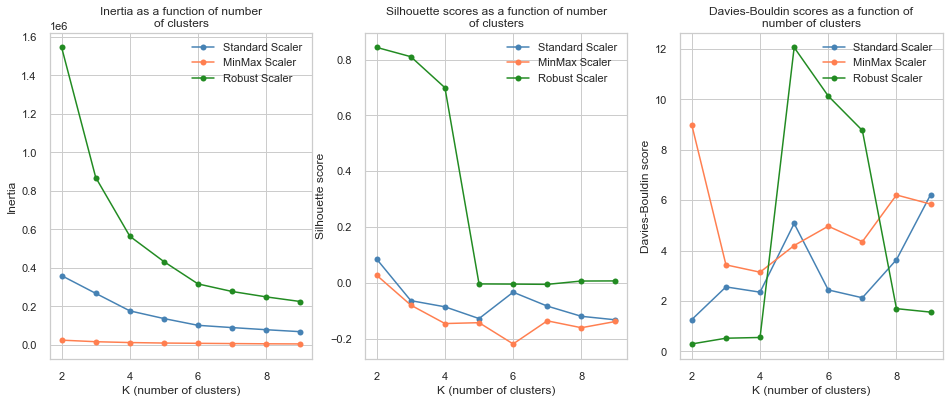

In [61]:
# Plotting results of the score metrics as a function of number of clusters and scalers:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

scores = ['inertia', 'silhouette_score', 'davies_bouldin_score']
titles = ['Inertia as a function of number\nof clusters',
    'Silhouette scores as a function of number\nof clusters', 
    'Davies-Bouldin scores as a function of\nnumber of clusters']
y_labels = ['Inertia', 'Silhouette score', 'Davies-Bouldin score']

for axe, score, title, ylab in zip([0, 1, 2], scores, titles, y_labels):
    ax[axe].plot(range(2, 10), results_relational[score][:8], marker='o', color='steelblue', label='Standard Scaler')
    ax[axe].plot(range(2, 10), results_relational[score][8:16], marker='o', color='coral', label='MinMax Scaler')
    ax[axe].plot(range(2, 10), results_relational[score][16:], marker='o', color='forestgreen', label='Robust Scaler')
    ax[axe].set_title(title)
    ax[axe].set_xlabel('K (number of clusters)')
    ax[axe].set_ylabel(ylab)
    ax[axe].legend()

#fig.savefig("rel_score.png", bbox_inches="tight", dpi=150);

The Robust Scaler gives the best overall scores and inertia. For inertia, the second is the Standard Scaler, the third the Min-Max Scaler. Forthe silhouette and Davies-Bouldin scores, the results are more contrasted and depends on the number of clusters.

In [49]:
# Transform data with various scalers:
X_scaled_robust_rel = RobustScaler().fit_transform(data_clustering_relational)
X_scaled_standard_rel = StandardScaler().fit_transform(data_clustering_relational)
X_scaled_minmax_rel = MinMaxScaler().fit_transform(data_clustering_relational)

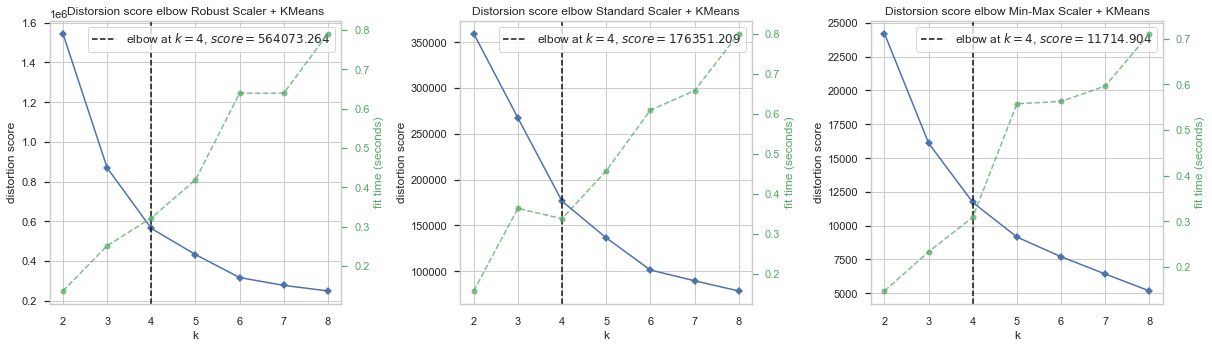

In [50]:
fig, (ax1, ax2, ax3)  = plt.subplots(1, 3, figsize=(17, 5), tight_layout=True)

visualizer = KElbowVisualizer(KMeans(random_state=0), ax=ax1, k=(2,9), 
    title='Distorsion score elbow Robust Scaler + KMeans')
visualizer.fit(X_scaled_robust_rel)
visualizer.finalize()

visualizer = KElbowVisualizer(KMeans(random_state=0), ax=ax2, k=(2,9),
    title='Distorsion score elbow Standard Scaler + KMeans')
visualizer.fit(X_scaled_standard_rel)
visualizer.finalize()

visualizer = KElbowVisualizer(KMeans(random_state=0), ax=ax3, k=(2,9),
    title='Distorsion score elbow Min-Max Scaler + KMeans')
visualizer.fit(X_scaled_minmax_rel)
visualizer.finalize()

#fig.savefig("rel_elbow.png", bbox_inches="tight", dpi=150);

With the Robust Scaler, the best number of cluster given by the elbow method is 3, 5 for the Standard Scaler and 4 the Min-Max Scaler.

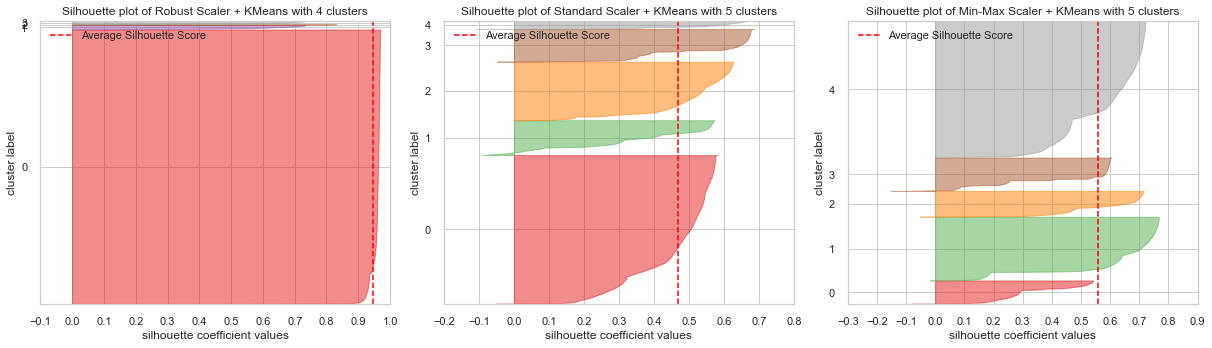

In [67]:
fig, (ax1, ax2, ax3)  = plt.subplots(1, 3, figsize=(17, 5), tight_layout=True)

visualizer = SilhouetteVisualizer(KMeans(4, random_state=0), ax=ax1,
    title='Silhouette plot of Robust Scaler + KMeans with 4 clusters')
visualizer.fit(X_scaled_robust_rel)
visualizer.finalize()

visualizer = SilhouetteVisualizer(KMeans(5, random_state=0), ax=ax2,
    title='Silhouette plot of Standard Scaler + KMeans with 5 clusters')
visualizer.fit(X_scaled_standard_rel)
visualizer.finalize()

visualizer = SilhouetteVisualizer(KMeans(5, random_state=0), ax=ax3,
    title='Silhouette plot of Min-Max Scaler + KMeans with 5 clusters')
visualizer.fit(X_scaled_minmax_rel)
visualizer.finalize()

#fig.savefig("rel_silplot.png", bbox_inches="tight", dpi=150);

The Robust Scaler with 3 clusters will give groups with very different proportions, including one very small and one with low silhouette score. The Standard Scaler at 5 clusters will give very disproportioned groups with variable silhouette scores. The Min-Max scaler with 5 clusters gives well shaped groups with  consistent silhouette scores, although 2 groups are significantly larger than the 3 others. 

We will use the Standard Scaler, since it is the best compromise betwen inertia, silhouette and Davies-Bouldin scores and explicability.

In [51]:
# Use the scaled data for CPA:
pca = PCA(n_components=2)
pca.fit(X_scaled_standard_rel)
X_trans = pca.transform(X_scaled_standard_rel)

In [52]:
# Get data for 3 clusters:
cls_standard_4 = make_pipeline(StandardScaler(), KMeans(n_clusters=4, random_state=0))
cls_standard_4.fit(data_clustering_relational)

# Get data for 4 clusters:
cls_standard_5 = make_pipeline(StandardScaler(), KMeans(n_clusters=5, random_state=0))
cls_standard_5.fit(data_clustering_relational)

# Get data for 5 clusters:
cls_standard_6 = make_pipeline(StandardScaler(), KMeans(n_clusters=6, random_state=0))
cls_standard_6.fit(data_clustering_relational)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=6, random_state=0))])

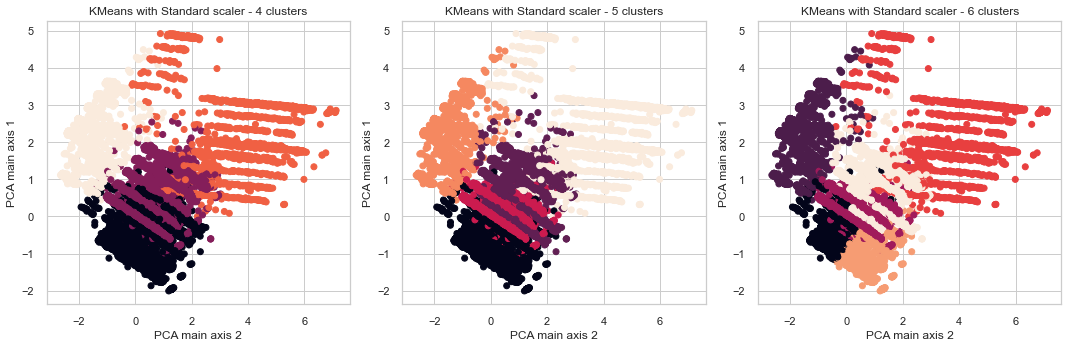

In [58]:
# Compare clustering at 4, 5, 6 clusters with projection on the first 2 main CPA axis:
labels = [
    cls_standard_4[-1].labels_, cls_standard_5[-1].labels_, cls_standard_6[-1].labels_
    ]
titles = [
    'KMeans with Standard scaler - 4 clusters', 'KMeans with Standard scaler - 5 clusters', 'KMeans with Standard scaler - 6 clusters'
    ]

fig, ax = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

for axe, label, title in zip([0, 1, 2], labels, titles):
    ax[axe].scatter(X_trans[:, 1], X_trans[:, 0], c=label)
    ax[axe].set_title(title)
    ax[axe].set_xlabel('PCA main axis 2')
    ax[axe].set_ylabel('PCA main axis 1')

#fig.savefig("rel_clusters.png", bbox_inches="tight", dpi=150);

C:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


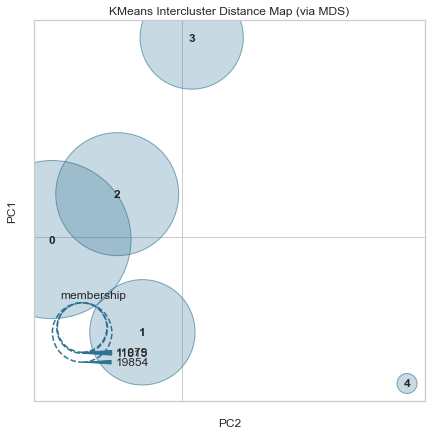

In [60]:
fig, ax = plt.subplots(figsize=(7, 7))

intercluster_distance(KMeans(5, random_state=0), X_scaled_standard_rel, ax=ax);

The groups are separated along both the first and second main CPA axis. Visually, the separation looks better for 4 clusters, but the elbow method suggests that the best number of clusters is 5.

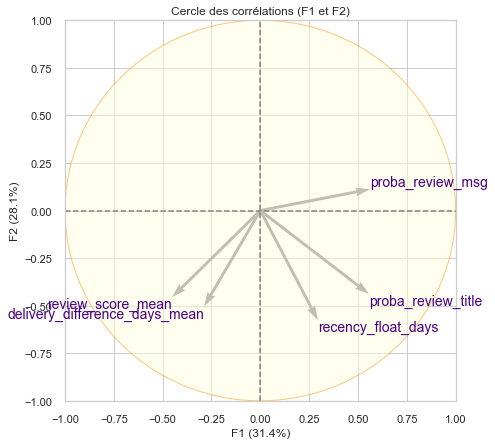

In [13]:
pcs = pca.components_
features = [
    'delivery_difference_days_mean', 'review_score_mean', 'proba_review_title', 
    'recency_float_days', 'proba_review_msg'
    ]
display_circles(pcs, 2, pca, [(0,1)], labels = np.array(features))

The second CPA axis is more correlated with the probability for a customer to leave a review message (points on the right side of the plot). The high review scores are correlated with an important (positive) difference between expected and true delivery date, meaning packages delivered in advance, and correspond to the lower left part of the correlation circle. Finally, the probability to add a title to the review is slightly correlated to the recency and groups points in the lower right part of the diagram.

Although the best number of clusters defined with the elbow method is 5, 4 clusters seem more reasonable given the graphic representation and has a better explicability.

In [15]:
# Compare mean of each variables for 4 clusters:
data_clustering_relational['cluster'] = cls_standard_5[-1].labels_
mean_rel_standard_5 = data_clustering_relational.groupby('cluster').mean()

# Add percentage of customer per cluster:
perc_cust_rel = data_clustering_relational.groupby('cluster').count() / data_clustering_relational.shape[0] * 100
perc_cust_rel.drop(columns=['delivery_difference_days_mean', 'review_score_mean', 
    'proba_review_title', 'recency_float_days'], inplace=True)
perc_cust_rel.rename(columns={'proba_review_msg':'percentage of customers'}, inplace=True)
mean_rel_standard_5 = pd.concat([mean_rel_standard_5, perc_cust_rel], axis=1)

# Rename index
mean_rel_standard_5.reset_index(inplace=True)
mean_rel_standard_5

,cluster,delivery_difference_days_mean,review_score_mean,proba_review_title,recency_float_days,proba_review_msg,percentage of customers
0,0,11.68,4.58,0.00,-287.65,0.00,52.57
1,1,2.23,1.50,0.00,-308.30,0.76,12.30
2,2,12.17,4.66,0.00,-362.14,1.00,20.68
3,3,10.17,3.99,0.99,-121.98,0.85,11.54
4,4,-1116.15,1.73,0.13,-345.82,0.67,2.91


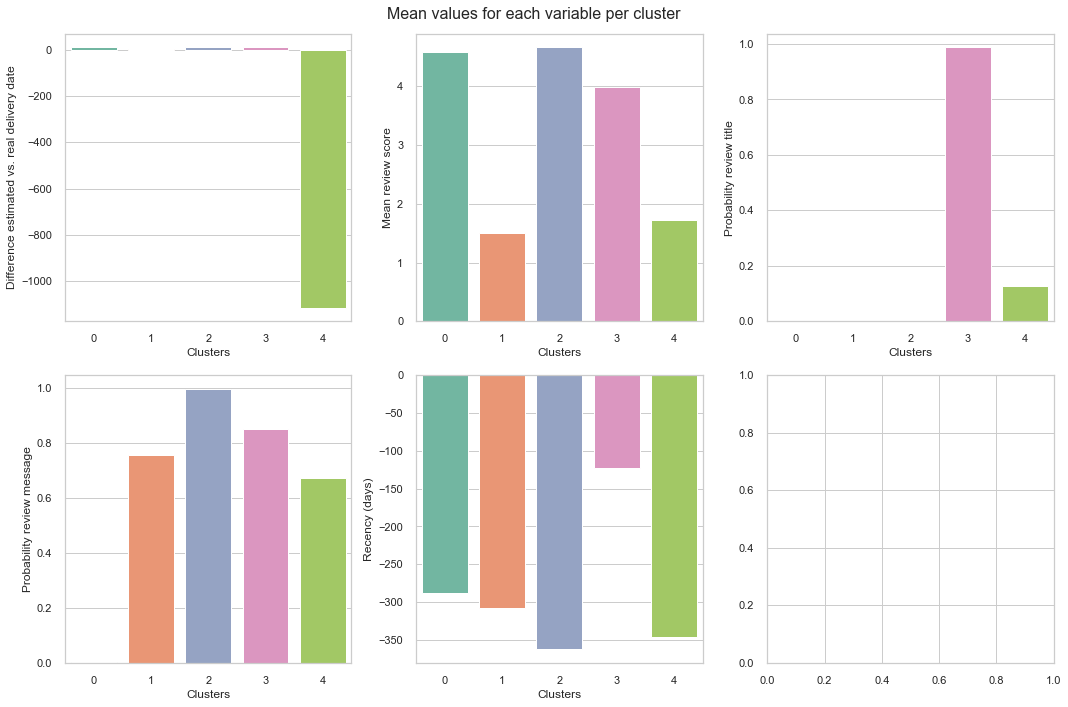

In [16]:
y_label =[
    'Difference estimated vs. real delivery date', 'Mean review score', 'Probability review title', 
    'Probability review message', 'Recency (days)'
    ]
data_mean = [
    'delivery_difference_days_mean', 'review_score_mean', 'proba_review_title', 
'proba_review_msg', 'recency_float_days'
    ]
axes = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1)]

fig, ax = plt.subplots(2, 3, figsize=(15, 10), tight_layout=True)
fig.suptitle('Mean values for each variable per cluster')
relational_colors=sns.color_palette("Set2", 5)

for axe, data, ylab in zip(axes, data_mean, y_label):
    sns.barplot(ax=ax[axe], data=mean_rel_standard_5, y=data, x='cluster', hue='cluster', ci=95, 
        palette=relational_colors, dodge=False)
    ax[axe].set_xticks(mean_rel_standard_5.index)
    ax[axe].set_xticklabels(mean_rel_standard_5.cluster)
    ax[axe].set_xlabel('Clusters')
    ax[axe].set_ylabel(ylab)
    ax[axe].legend([], [], frameon=False)

#fig.savefig("rel_means.png", bbox_inches="tight", dpi=150);

* Satisfied, shy, 10 mounths customers : we have one cluster of about 53% of customer satisfied but who do not write any review message. They correspond to moderately recent clients (last order about 10 mounth ago).
* Satisfied, talkative, old customers : another cluster of about 20% of customers group satisfied clients who wrote review messages for all orders (but without title), and are ancient customers (last order about 1 year ago)
* Disatisfied by delivery, talkative, old customers : another cluster of about 3% of clients are disatisfied clients (low review score), writing review message for about 2 out of 3 orders and sometimes with a title. The reason of disatisfaction is most probably a delivery problem (correspond to lost packages, unavailable orders, etc).
* Disatisfied for unknown reason, talkative, 10 mounth customers : about 12% of the customers are disatisfied, apparently not related to delivery problems. They leave a review message for about 3 orders out of 4 and are moderately recent (last order about 10 mounth ago).
* Satisfied, talkative, recent customers : this cluster of about 12% of clients corresponds to satisfied customers often writing review messages with title and are quite recent (last order about 4 mounth ago).

Recommandation of actions for each cluster:
* Satisfied, shy, 10 mounths customers (53%): activate this segment with appropriate commercials, they are likely to buy more products.
* Satisfied, talkative, old customers (20%) : no action to suggest: they already express their satisfaction in reviews and will be difficult too activate with new campains, they are lost for the company.
* Disatisfied by delivery, talkative, old customers (3%): no action to suggest: they already wrote bad reviews and the reason is clearly a lack of delivery. Getting them back will be too difficult and they represent only 3% of customers.
* Disatisfied for unknown reason, talkative, 10 mounth customers (12%): analyse the content of their reviews to understand the reasons of disatisfaction, make surveys for customers who didn't wrote a review.
* Satisfied, talkative, recent customers (12%): encourage this segment to share their good experience with Olist on social medias, offer patronage opportunities for their friends and relatives to gain new customers, target them with appropriate comemrcials.

## Clusters' stability over time

We will check the clusters'stability for the relational clustering busing the `adjusted_rand_score` function. The ARI compares two arrays of labels and compute the proportion of identical labels. We will make a dataset with all data of 2016 and 2017 customers. Then make test datasets containing 2016-2017 data + 1 mounth (including january 2018), then 2016-2017 + 2 mounths (including january-february 2018), etc...
The true labels of the ARI will be the labels attributed by the base clustering of 2016-2017. The predicted labels will be the ones defined by the `predict` function on the augmented dataset (that simulate the addition of new clients) for the 2016-2017 clients. We will see if the labels attributed are similar or different for each mounth and be able to evaluate the clusters' stability.

In [9]:
data_relational_ari = customers_unique[
    ['delivery_difference_days_mean', 'review_score_mean', 'proba_review_title', 'recency_float_days', 
    'proba_review_msg', 'most_recent_order']
    ].copy()

In [10]:
data_relational_ari.head()

,delivery_difference_days_mean,review_score_mean,proba_review_title,recency_float_days,proba_review_msg,most_recent_order
0,4.13,5.00,1.00,-160.27,1.00,2018-05-10 10:56:27
1,4.25,4.00,0.00,-163.26,0.00,2018-05-07 11:11:27
2,1.39,3.00,0.00,-585.85,0.00,2017-03-10 21:05:03
3,11.11,4.00,0.00,-369.88,1.00,2017-10-12 20:29:41
4,7.04,5.00,0.00,-336.91,0.00,2017-11-14 19:45:42


In [11]:
# Filtering data for 2016-2017 orders:
data_relational_ari_base = data_relational_ari[
    data_relational_ari['most_recent_order']<'2018-01-01 00:00:00'
    ].copy()

data_relational_ari_base.reset_index(inplace=True)
data_relational_ari_base.drop(columns=['index', 'most_recent_order'], inplace=True)

In [12]:
# Filtering data for each mounth of 2018:
data_relational_ari_mounth01 = data_relational_ari[
    (data_relational_ari['most_recent_order']>='2018-01-01 00:00:00') & (data_relational_ari['most_recent_order']<'2018-02-01 00:00:00')
].copy()
data_relational_ari_mounth02 = data_relational_ari[
    (data_relational_ari['most_recent_order']>='2018-02-01 00:00:00') & (data_relational_ari['most_recent_order']<'2018-03-01 00:00:00')
].copy()
data_relational_ari_mounth03 = data_relational_ari[
    (data_relational_ari['most_recent_order']>='2018-03-01 00:00:00') & (data_relational_ari['most_recent_order']<'2018-04-01 00:00:00')
].copy()
data_relational_ari_mounth04 = data_relational_ari[
    (data_relational_ari['most_recent_order']>='2018-04-01 00:00:00') & (data_relational_ari['most_recent_order']<'2018-05-01 00:00:00')
].copy()
data_relational_ari_mounth05 = data_relational_ari[
    (data_relational_ari['most_recent_order']>='2018-05-01 00:00:00') & (data_relational_ari['most_recent_order']<'2018-06-01 00:00:00')
].copy()
data_relational_ari_mounth06 = data_relational_ari[
    (data_relational_ari['most_recent_order']>='2018-06-01 00:00:00') & (data_relational_ari['most_recent_order']<'2018-07-01 00:00:00')
].copy()
data_relational_ari_mounth07 = data_relational_ari[
    (data_relational_ari['most_recent_order']>='2018-07-01 00:00:00') & (data_relational_ari['most_recent_order']<'2018-08-01 00:00:00')
].copy()
data_relational_ari_mounth08 = data_relational_ari[
    data_relational_ari['most_recent_order']>='2018-08-01 00:00:00'
].copy()

In [13]:
print(f'Data for 2016 and 2017 contains {data_relational_ari_base.shape[0]} customers.')
print(f'Data for January 2018 add {data_relational_ari_mounth01.shape[0]} customers.')
print(f'Data for February 2018 add {data_relational_ari_mounth02.shape[0]} customers.')
print(f'Data for March 2018 add {data_relational_ari_mounth03.shape[0]} customers.')
print(f'Data for April 2018 add {data_relational_ari_mounth04.shape[0]} customers.')
print(f'Data for May 2018 add {data_relational_ari_mounth05.shape[0]} customers.')
print(f'Data for June 2018 add {data_relational_ari_mounth06.shape[0]} customers.')
print(f'Data for July 2018 add {data_relational_ari_mounth07.shape[0]} customers.')

Data for 2016 and 2017 contains 43310 customers.
Data for January 2018 add 7023 customers.
Data for February 2018 add 6447 customers.
Data for March 2018 add 7012 customers.
Data for April 2018 add 6777 customers.
Data for May 2018 add 6742 customers.
Data for June 2018 add 6077 customers.
Data for July 2018 add 6176 customers.


The test datasets will be augmented by about 6000-7000 customers at each steps.

In [14]:
# Concatenate to create augmented datasets:
data_relational_ari_01 = pd.concat([data_relational_ari_base, data_relational_ari_mounth01])
data_relational_ari_02 = pd.concat([data_relational_ari_01, data_relational_ari_mounth02])
data_relational_ari_03 = pd.concat([data_relational_ari_02, data_relational_ari_mounth03])
data_relational_ari_04 = pd.concat([data_relational_ari_03, data_relational_ari_mounth04])
data_relational_ari_05 = pd.concat([data_relational_ari_04, data_relational_ari_mounth05])
data_relational_ari_06 = pd.concat([data_relational_ari_05, data_relational_ari_mounth06])
data_relational_ari_07 = pd.concat([data_relational_ari_06, data_relational_ari_mounth07])
data_relational_ari_08 = pd.concat([data_relational_ari_07, data_relational_ari_mounth08])

In [15]:
list_X_aug = [data_relational_ari_01, data_relational_ari_02, data_relational_ari_03, data_relational_ari_04, data_relational_ari_05,
    data_relational_ari_06, data_relational_ari_07, data_relational_ari_08]

In [16]:
# Clean index and drop unusefull columns:
for data in list_X_aug:
    data.reset_index(inplace=True)
    data.drop(columns=['index', 'most_recent_order'], inplace=True)

In [17]:
# make a dict for futur use:
dict_X_aug = {1:data_relational_ari_01, 2:data_relational_ari_02, 3:data_relational_ari_03, 
    4:data_relational_ari_04, 5:data_relational_ari_05,
    6:data_relational_ari_06, 7:data_relational_ari_07, 8:data_relational_ari_08}

In [18]:
data_relational_ari_01.head()

,delivery_difference_days_mean,review_score_mean,proba_review_title,recency_float_days,proba_review_msg
0,1.39,3.00,0.00,-585.85,0.00
1,11.11,4.00,0.00,-369.88,1.00
2,7.04,5.00,0.00,-336.91,0.00
3,27.64,4.00,0.00,-591.75,0.00
4,11.22,3.00,0.00,-456.34,1.00


Now we will have a look at the base data and fit the clustering model on the 2016-2017 data:

In [21]:
# Scale base data :
X_scaled_ari_base = StandardScaler().fit_transform(data_relational_ari_base)

# Use the scaled data for CPA:
pca_ari = PCA(n_components=2)
pca_ari.fit(X_scaled_ari_base)
X_trans_ari = pca_ari.transform(X_scaled_ari_base)


In [22]:
# Fit model on base data:
cls_ari_base = make_pipeline(StandardScaler(), KMeans(n_clusters=5))
cls_ari_base.fit(data_relational_ari_base)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=5))])

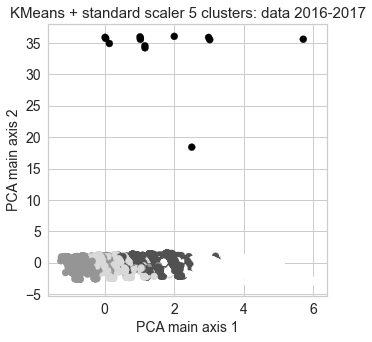

In [23]:
# Base clustering for 2016-2017 data:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(X_trans_ari[:, 0], X_trans_ari[:, 1], c=cls_ari_base[-1].labels_)
ax.set_title('KMeans + standard scaler 5 clusters: data 2016-2017')
ax.set_xlabel('PCA main axis 1')
ax.set_ylabel('PCA main axis 2');

This is the position of the clusters when the model is applied to the 2016-2017 data only.

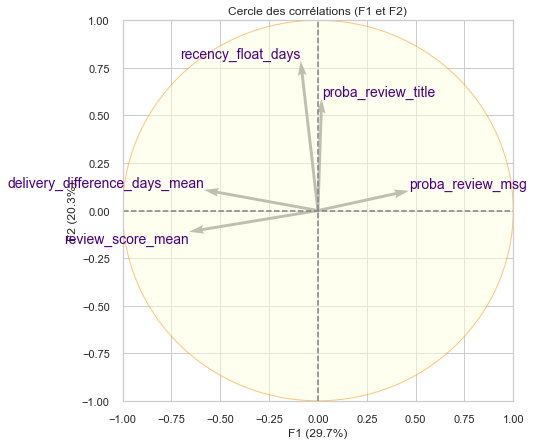

In [24]:
# Corresponding CPA axis:
pcs_ari = pca_ari.components_
features = [
    'delivery_difference_days_mean', 'review_score_mean', 'proba_review_title', 
    'recency_float_days', 'proba_review_msg'
    ]
display_circles(pcs_ari, 2, pca_ari, [(0,1)], labels = np.array(features))

The CPA is similar to the model fit on the whole data, the orientation of axis is simply reversed.

In [25]:
# Compare mean of each variables for 4 clusters:
data_relational_ari_base['cluster'] = cls_ari_base[-1].labels_
mean_rel_ari_base = data_relational_ari_base.groupby('cluster').mean()

# Add percentage of customer per cluster:
perc_cust_ari_base = data_relational_ari_base.groupby('cluster').count() / data_relational_ari_base.shape[0] * 100
perc_cust_ari_base.drop(columns=['delivery_difference_days_mean', 'review_score_mean', 
    'proba_review_title', 'recency_float_days'], inplace=True)
perc_cust_ari_base.rename(columns={'proba_review_msg':'percentage of customers'}, inplace=True)
mean_rel_standard_5 = pd.concat([mean_rel_ari_base, perc_cust_ari_base], axis=1)

# Rename index
mean_rel_ari_base.reset_index(inplace=True)
#mean_rel_standard_5['cluster'].replace({0:'Disatisfied_by_delivery_Talkative', 1:'Satisfied_Shy', 2:'Satisfied_Talkative_Recent', 
    #3:'Disatisfied_UnknownReason_Talkative'}, inplace=True)
mean_rel_ari_base

,cluster,delivery_difference_days_mean,review_score_mean,proba_review_title,recency_float_days,proba_review_msg
0,0,-1229.46,1.71,0.00,-459.69,0.67
1,1,12.52,4.68,0.00,-440.74,1.00
2,2,11.94,4.57,0.00,-427.12,0.00
3,3,4.46,1.54,0.00,-409.97,0.79
4,4,-117.97,3.73,0.96,-367.86,0.73


We find the same type of clusters as analysed before.

In [26]:
# Clean base data:
data_relational_ari_base.drop('cluster', axis=1, inplace=True)

In [27]:
def ari_predict(X_base, dict_X_augmented, model, refit=False):

    """
    Calculate Adjusted Rand Scores for a dict of dataframes comparing each one to a 
    base one (ground truth).
    The function will fit model, make the predictions and compute ARI.
    Return a list of ARI.

    X_base: array, df
    Base data that will be used for comparison.

    dict_X_augmented: dict of df
    Dictionnary of df containing data to use for prediction.

    model: clustering model.

    refit: bool
    Indicate if use the model fitted on the base data or if refit on ugmented data 
    at each step.

    """
    n_data_base = X_base.shape[0]
    result = [1]
    n = len(dict_X_aug)

    #Fit model on base data:
    model.fit(X_base)
    true_clusters = model[-1].labels_

    # Get ARI for each augmented dataset:
    for i in range(0, n):
        if refit:
            model.fit(dict_X_augmented[i])
        labels = model.predict(dict_X_augmented[i])

        ari = adjusted_rand_score(true_clusters, labels[:n_data_base])
        result.append(ari)

    return result

In [28]:
# Calculate ARI for each augmented dataset:
ari_predicted = ari_predict(data_relational_ari_base, list_X_aug, cls_ari_base)
ari_predicted

[1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [29]:
# Calculate ARI for each augmented dataset with refit:
ari_fit_predicted = ari_predict(data_relational_ari_base, list_X_aug, cls_ari_base, refit=True)
ari_fit_predicted

[1,
 0.9944962107494816,
 0.9837106250953005,
 0.9730788619297162,
 0.9797400408446912,
 0.9781312046920912,
 0.9768196625561071,
 0.9747620613032366,
 0.9728681792702978]

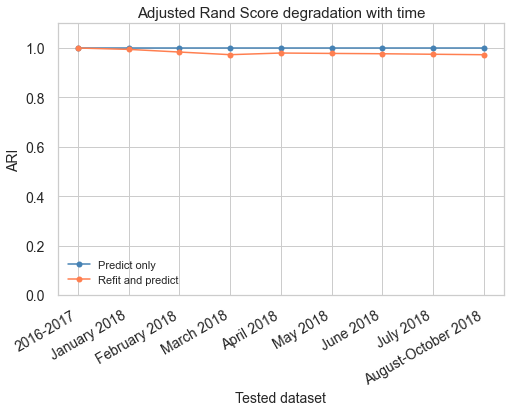

In [33]:
fig, ax = plt.subplots(figsize=(8,5))
dates = [
    '2016-2017', 'January 2018', 'February 2018', 'March 2018', 'April 2018', 
    'May 2018', 'June 2018', 'July 2018', 'August-October 2018'
    ]
ax.plot(dates, ari_predicted, marker='o', color='steelblue', label='Predict only')
ax.plot(dates, ari_fit_predicted, marker='o', color='coral', label='Refit and predict')
ax.set_title('Adjusted Rand Score degradation with time')
ax.set_ylabel('ARI')
ax.set_xlabel('Tested dataset')
ax.set_xticks(dates)
ax.set_xticklabels(dates, rotation=30, ha='right')
ax.set(ylim=(0, 1.1))
ax.legend()

#fig.savefig("ARI.png", bbox_inches="tight", dpi=150);

Our model correctly predict labels of 2016-2017 clients even with addition of new clients, even when centroids are refitted. We can therefore recommand maintenance once a year only.